# Istanbul Weather Forecasting wiht RNN

# Imports

In [ ]:
# !pip install keras-tuner

In [ ]:
import random, datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from keras_tuner import HyperModel, HyperParameters
from keras_tuner.tuners import RandomSearch

random.seed(46)
np.random.seed(46)
tf.random.set_seed(46)


# Functions

In [ ]:
def load_and_preprocess(data_path):
    
    data = pd.read_csv(data_path)
    
    data['temp_celsius'] = data['temp'] - 273.15
    # data['date'] = pd.to_datetime(data['dt_iso']).dt.date
    data['date'] = pd.to_datetime(data['dt_iso'], format='%Y-%m-%d %H:%M:%S +0000 UTC').dt.date
    data = data.drop(columns=['dt_iso', 'temp'])
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)
    
    return data.resample('D').mean()

def split_data_by_time(df, train_frac=0.7, val_frac=0.15):
    
    n = len(df)
    
    train_size = int(n * train_frac)
    val_size = int(n * val_frac)
    test_size = n - train_size - val_size
    
    train_df = df[:train_size]
    val_df = df[train_size:train_size+val_size]
    test_df = df[train_size+val_size:]
    
    return train_df, val_df, test_df


def scale_data(train_df, val_df, test_df, feature_columns, target_column):
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    scaler_x.fit(train_df[feature_columns])
    scaler_y.fit(train_df[[target_column]])
    
    train_x = scaler_x.transform(train_df[feature_columns])
    val_x = scaler_x.transform(val_df[feature_columns])
    test_x = scaler_x.transform(test_df[feature_columns])
    
    train_y = scaler_y.transform(train_df[[target_column]])
    val_y = scaler_y.transform(val_df[[target_column]])
    test_y = scaler_y.transform(test_df[[target_column]])
    
    return train_x, val_x, test_x, train_y.flatten(), val_y.flatten(), test_y.flatten(), scaler_x, scaler_y

def create_timewindow(X, y, time_steps=1):
    Xs, ys = [], []
    
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
        
    return np.array(Xs), np.array(ys), time_steps

def plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):

    #Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_loss], label='Training Loss')
    plt.plot(history.history[val_loss], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Metrics
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_metric], label=f"Training: {train_metric}")
    plt.plot(history.history[val_metric], label=f"Validation: {val_metric}")
    plt.title(f'Training and Validation {train_metric} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(f'train_metric')
    plt.legend()
    plt.show()


def evaluate_predictions(model, X_train, y_train, X_val, y_val, X_test, y_test, scaler_y):

    y_train_pred_ = model.predict(X_train, verbose=0)
    y_val_pred = model.predict(X_val, verbose=0)
    y_test_pred = model.predict(X_test, verbose=0)

    true_y_train_pred = scaler_y.inverse_transform(y_train_pred_)
    true_y_val_pred = scaler_y.inverse_transform(y_val_pred)
    true_y_test_pred = scaler_y.inverse_transform(y_test_pred)

    true_y_train = scaler_y.inverse_transform(y_train.reshape(-1, 1))
    true_y_val = scaler_y.inverse_transform(y_val.reshape(-1, 1))
    true_y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

    train_mse = mean_squared_error(true_y_train, true_y_train_pred)
    val_mse = mean_squared_error(true_y_val, true_y_val_pred)
    test_mse = mean_squared_error(true_y_test, true_y_test_pred)
    
    print("Train MSE:", train_mse, "Validation MSE:", val_mse, "Test MSE:", test_mse)
    
    return true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse


def plot_predictions_with_metrics(train_df, val_df, test_df, true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse, time_steps):
    plt.figure(dpi=200)
    plt.figure(figsize=(30, 10))
    
    # Train
    train_time = train_df.index[time_steps:]
    plt.plot(train_time, true_y_train, label='True Values (Train)', color='blue')
    plt.plot(train_time, true_y_train_pred, '--', label='Predicted Values (Train)', color='red')

    # Validation
    val_time = val_df.index[time_steps:]
    plt.plot(val_time, true_y_val, label='True Values (Validation)', color='green')
    plt.plot(val_time, true_y_val_pred, '--', label='Predicted Values (Validation)', color='orange')

    # Test
    test_time = test_df.index[time_steps:]
    plt.plot(test_time, true_y_test, label='True Values (Test)', color='purple')
    plt.plot(test_time, true_y_test_pred, '--', label='Predicted Values (Test)', color='pink')

    # Metrics
    plt.text(train_time.min(), true_y_train.max()*1.03, f"Train MSE: {train_mse:.4f}", fontsize=12)
    plt.text(train_time.min(), true_y_train.max()*0.98, f"Validation MSE: {val_mse:.4f}", fontsize=12)
    plt.text(train_time.min(), true_y_train.max()*0.93, f"Test MSE: {test_mse:.4f}", fontsize=12)

    plt.title('Actual and Predicted Values for All Data Sets')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_individual_series(data, figsize=(12, 4)):
    for column in data.columns:
        plt.figure(figsize=figsize)
        plt.plot(data.index, data[column], label=column, color='b')
        plt.title(f'Time Series Visualisation - {column}')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.grid(True)
        plt.legend()
        plt.show()

# Data Set

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = "../five_years_ist_weather.csv"

# Data Preparation

In [ ]:
df = load_and_preprocess(data_path)
print(df.head())

feature_columns=[col for col in df.columns if col != 'temp_celsius']
target_column='temp_celsius'

train_df, val_df, test_df = split_data_by_time(df, train_frac=0.7, val_frac=0.15)
print("Train Sizes:", train_df.shape, "Validation Sizes:", val_df.shape, "Test Sizes:", test_df.shape)

train_scaled_x, val_scaled_x, test_scaled_x, train_scaled_y, val_scaled_y, test_scaled_y, scaler_x, scaler_y = scale_data(train_df, val_df, test_df, feature_columns, target_column)

X_train, y_train, time_steps = create_timewindow(train_scaled_x, train_scaled_y, time_steps = 5)
X_val, y_val, time_steps = create_timewindow(val_scaled_x, val_scaled_y, time_steps = 5)
X_test, y_test, time_steps = create_timewindow(test_scaled_x, test_scaled_y, time_steps = 5)

             humidity  wind_speed  clouds_all     pressure   dew_point  \
date                                                                     
2019-01-01  64.916667    5.473750   44.166667  1020.750000  273.427083   
2019-01-02  77.192308    3.921923   82.884615  1012.000000  275.625769   
2019-01-03  80.500000    5.600417   82.500000  1009.416667  275.659167   
2019-01-04  76.375000    7.986667   75.833333  1018.291667  272.872083   
2019-01-05  83.958333    6.635000   72.083333  1014.250000  274.025417   

            temp_celsius  
date                      
2019-01-01      6.390833  
2019-01-02      6.205000  
2019-01-03      5.622917  
2019-01-04      3.455833  
2019-01-05      3.334167  
Train Sizes: (1278, 6) Validation Sizes: (273, 6) Test Sizes: (275, 6)


In [ ]:
df.head()

,humidity,wind_speed,clouds_all,pressure,dew_point,temp_celsius
date,,,,,,
2019-01-01,64.916667,5.473750,44.166667,1020.750000,273.427083,6.390833
2019-01-02,77.192308,3.921923,82.884615,1012.000000,275.625769,6.205000
2019-01-03,80.500000,5.600417,82.500000,1009.416667,275.659167,5.622917
2019-01-04,76.375000,7.986667,75.833333,1018.291667,272.872083,3.455833
2019-01-05,83.958333,6.635000,72.083333,1014.250000,274.025417,3.334167


## Dataset analysis

In [ ]:
df.describe()

,humidity,wind_speed,clouds_all,pressure,dew_point,temp_celsius
count,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000
mean,70.896901,4.582238,31.097616,1015.936498,283.720919,16.221721
std,9.580190,1.858030,26.046656,6.175962,6.209948,7.202862
min,36.541667,0.792917,0.000000,991.625000,267.150000,-1.631667
25%,64.218750,3.150833,6.666667,1011.708333,279.051354,10.346979
50%,71.041667,4.401458,24.895833,1015.458333,283.752981,15.866042
75%,77.875000,5.763333,53.750000,1019.489583,288.946458,22.889479
max,96.750000,13.983333,100.000000,1038.750000,296.479167,31.163750


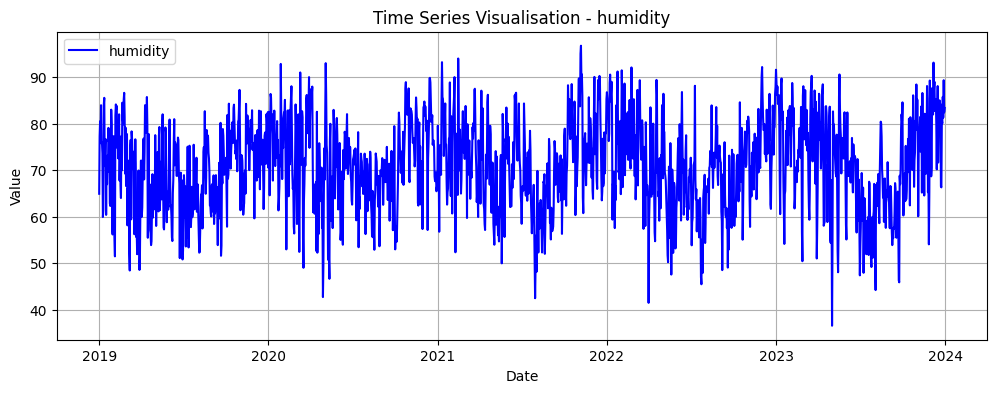

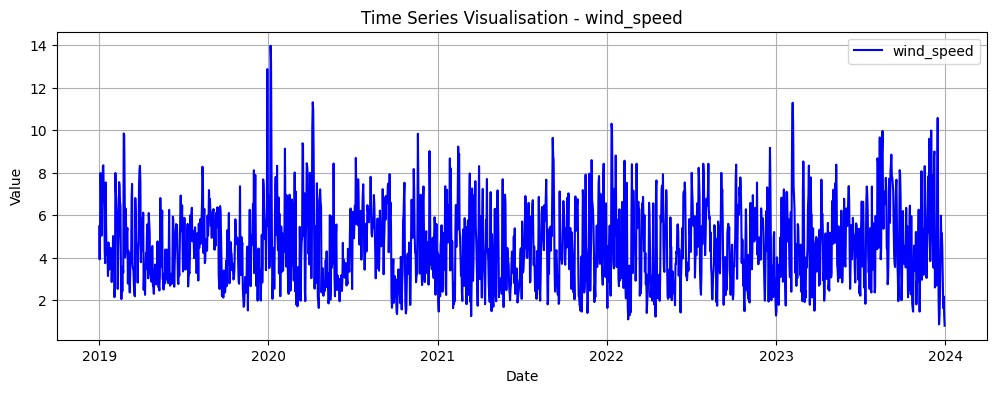

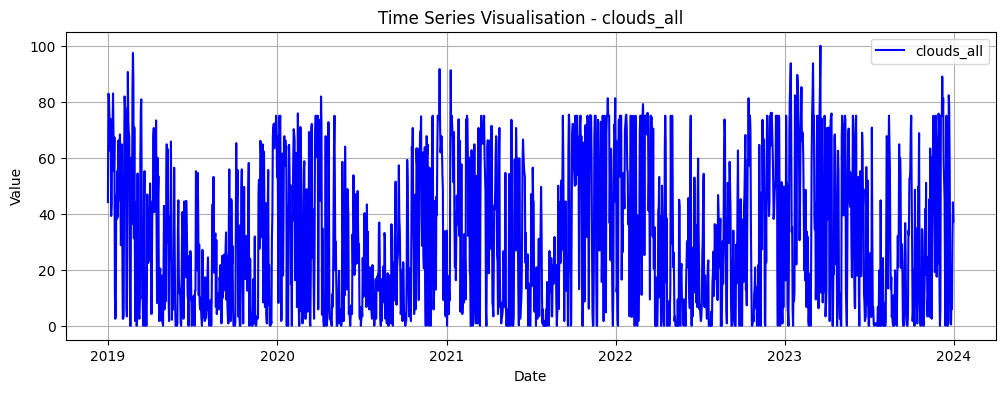

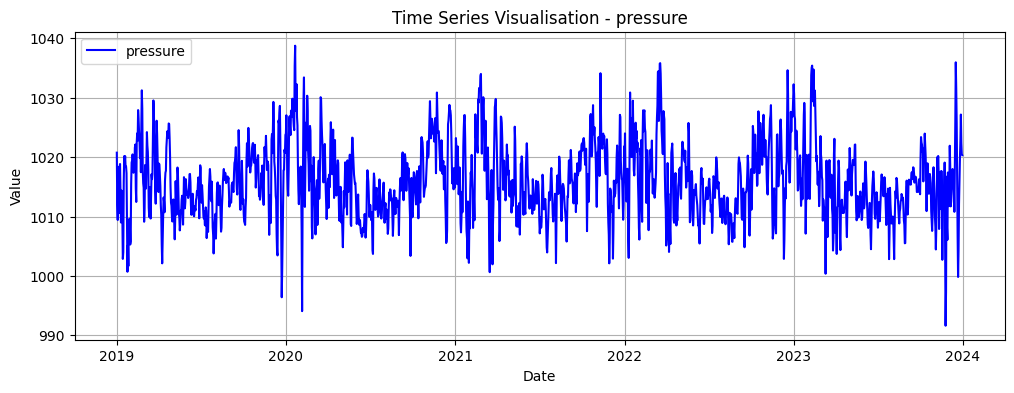

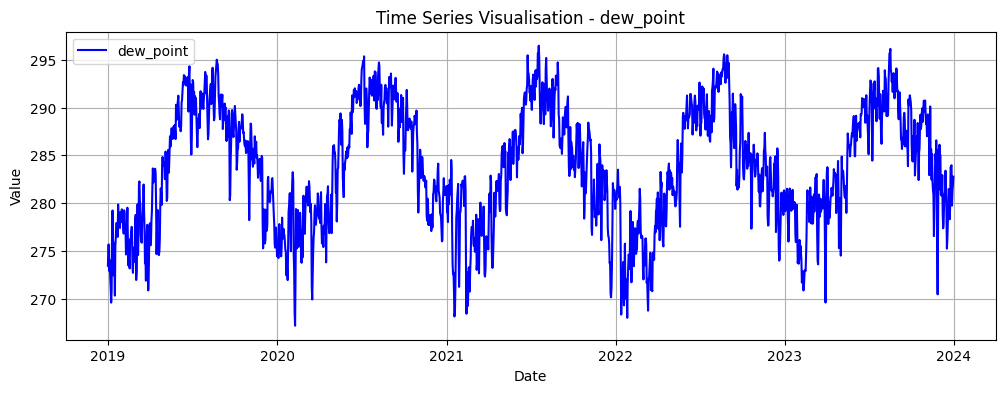

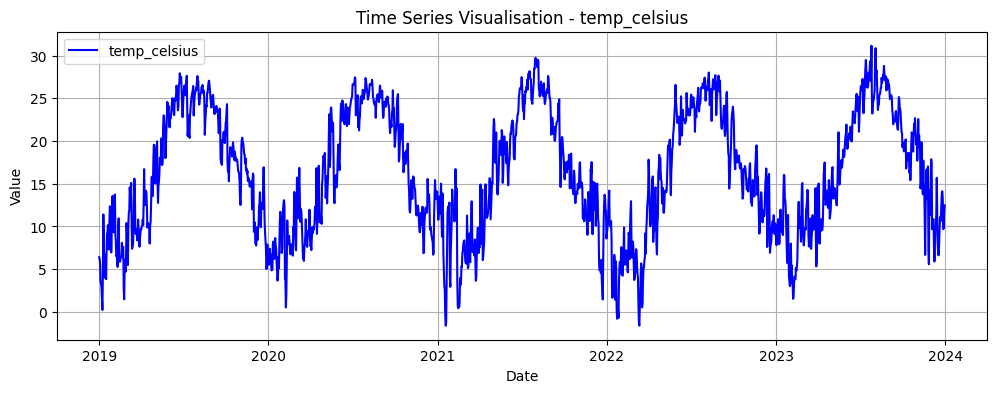

In [ ]:
plot_individual_series(df)

## LSTM Modelling

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])

model = Sequential([
        LSTM(50, input_shape=input_shape,
             kernel_regularizer=l2(0.001)),
        Dense(1)
    ])


optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mse'])

model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    restore_best_weights=True)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 11251 (43.95 KB)
Trainable params: 11251 (43.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Model training

In [ ]:
start_time = datetime.datetime.now()

history = model.fit(
    X_train, y_train,
    epochs=1000,
    validation_data=(X_val, y_val),
    batch_size=32,
    verbose=1,
    callbacks=early_stopping
)

end_time = datetime.datetime.now()

total_duration = end_time - start_time
print("Training Time:", total_duration)

Epoch 1/1000
40/40 [==============================] - 3s 16ms/step - loss: 0.1216 - mse: 0.1122 - val_loss: 0.0358 - val_mse: 0.0268
Epoch 2/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0227 - mse: 0.0143 - val_loss: 0.0190 - val_mse: 0.0111
Epoch 3/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0160 - mse: 0.0088 - val_loss: 0.0153 - val_mse: 0.0087
Epoch 4/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0139 - mse: 0.0077 - val_loss: 0.0134 - val_mse: 0.0078
Epoch 5/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0123 - mse: 0.0070 - val_loss: 0.0116 - val_mse: 0.0066
Epoch 6/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0109 - mse: 0.0062 - val_loss: 0.0102 - val_mse: 0.0058
Epoch 7/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0099 - mse: 0.0057 - val_loss: 0.0093 - val_mse: 0.0053
Epoch 8/1000
40/40 [==============================] - 0s 4ms/step - loss: 0

# Performance Evaluation

In [ ]:
train_loss = model.evaluate(X_train, y_train, verbose=0)
val_loss = model.evaluate(X_val, y_val, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Train Loss: {train_loss[0]}", f"Validation Loss: {val_loss[0]}", f"Test Loss: {test_loss[0]}")

Train Loss: 0.0030553911346942186 Validation Loss: 0.00275725731626153 Test Loss: 0.0035284992773085833


In [ ]:
true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse = evaluate_predictions(model, X_train, y_train, X_val, y_val, X_test, y_test, scaler_y)

Train MSE: 2.7302296826828742 Validation MSE: 2.436476514772559 Test MSE: 3.196386336063406


<Figure size 1280x960 with 0 Axes>

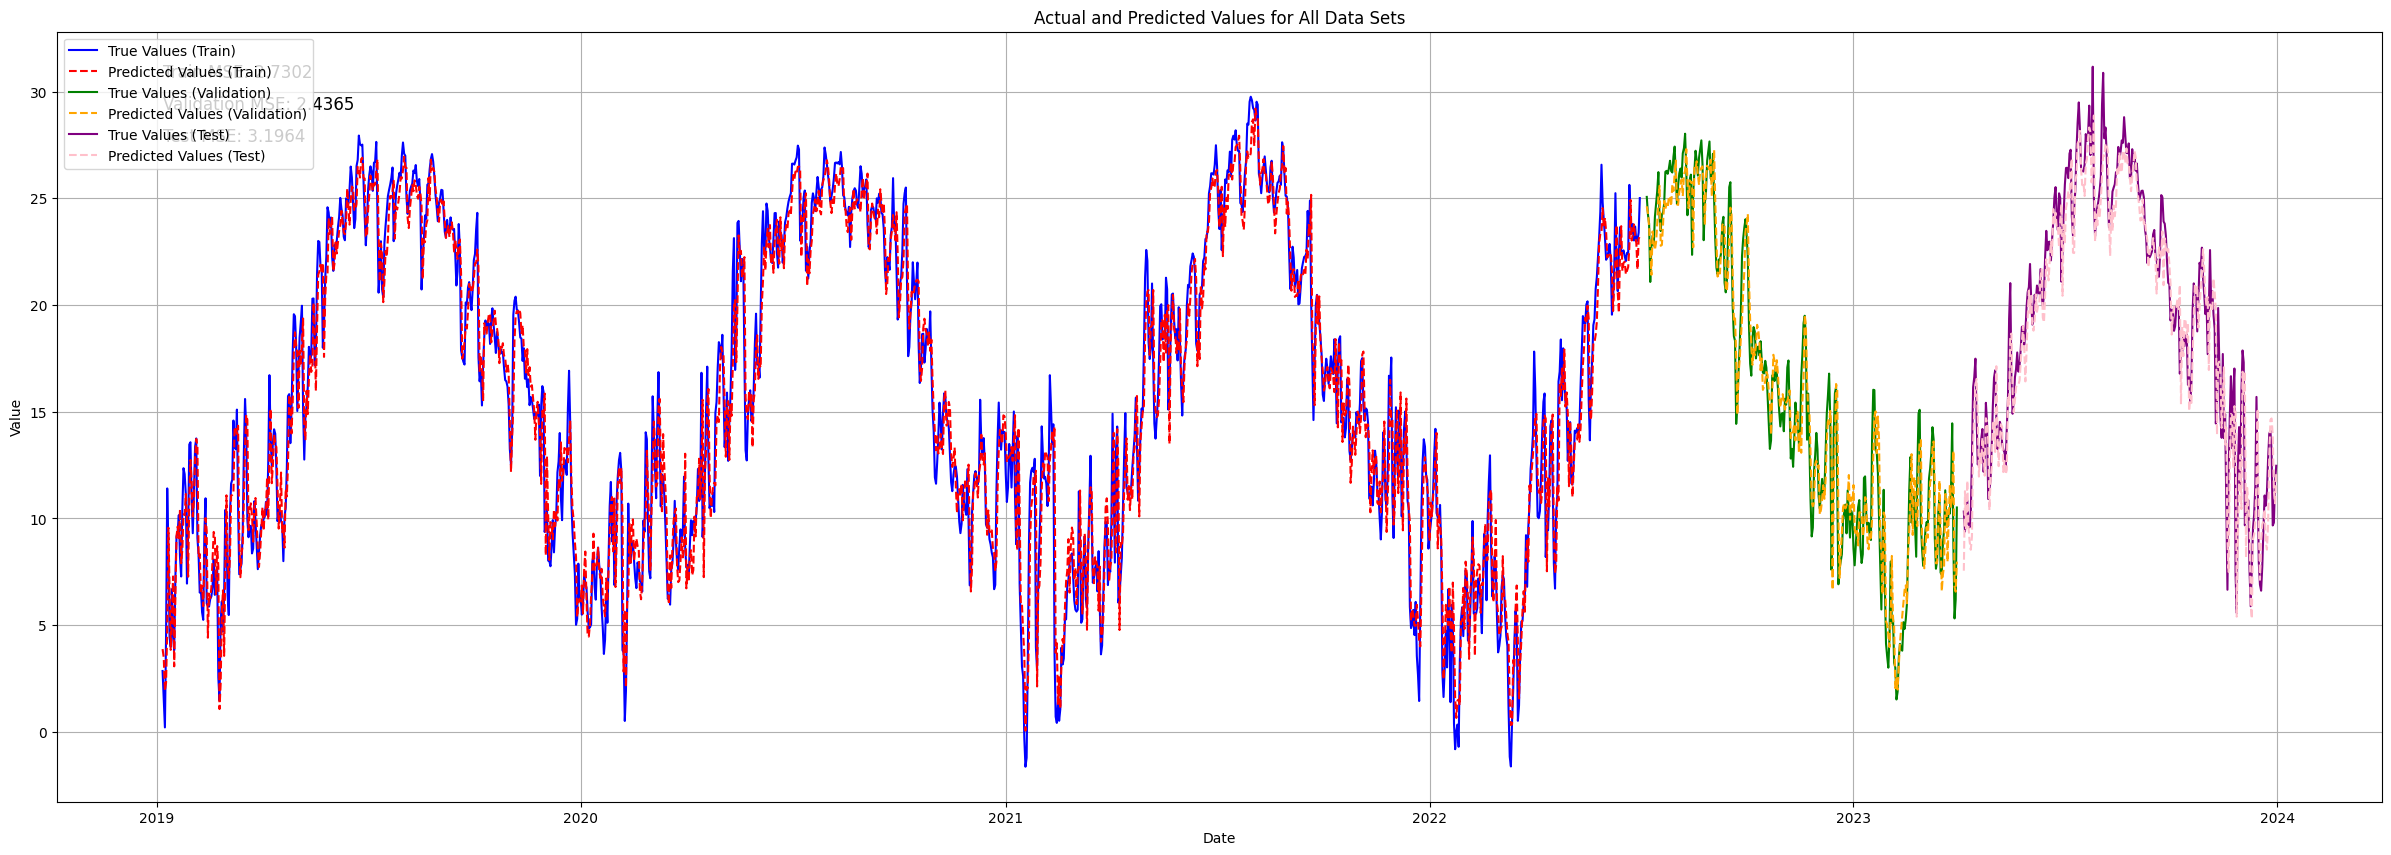

In [ ]:
plot_predictions_with_metrics(train_df, val_df, test_df, true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse, time_steps)

In [ ]:
true_y_test[-10:]

array([[10.59791667],
       [11.23833333],
       [12.77416667],
       [13.96375   ],
       [14.11958333],
       [13.19083333],
       [ 9.67125   ],
       [ 9.805     ],
       [11.74291667],
       [12.46875   ]])

In [ ]:
true_y_test_pred[-10:]

array([[ 8.901919],
       [ 8.538692],
       [ 9.716906],
       [12.918923],
       [14.617295],
       [14.684779],
       [13.912622],
       [11.309073],
       [10.710339],
       [12.094158]], dtype=float32)

## Hyperparameter Optimization For GRU

- Layer Numbers: 10
- Neuron Numbers: From 16 to 1024,  steps with 32 margin. (return_squences shall be handled according to this)
- Dropout:(0.0 - 0.5) with 0.1 steps.
- learning rate start value for ADAM: (1e-5, 1e-2).

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=input_shape))

    for i in range(hp.Int('num_layers', 1, 10)):
        
        model.add(GRU(units=hp.Int('units_' + str(i), min_value=16, max_value=1024, step=32),
                      return_sequences=(i < hp.Int('num_layers', 1, 10) - 1)))
        
        model.add(BatchNormalization())
        
        model.add(Dropout(hp.Float('dropout_' + str(i), min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-5, 1e-2, sampling='LOG')),
                  loss='mean_squared_error',
                  metrics=['mse'])

    return model

In [ ]:
random_search_tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='gru_tuning',
    overwrite=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True)

In [ ]:
random_search_tuner.search(X_train, y_train,
                           epochs=250,
                           validation_data=(X_val, y_val),
                           callbacks=[early_stopping])

Trial 20 Complete [00h 00m 44s]
val_loss: 0.07012014091014862

Best val_loss So Far: 0.0028309370391070843
Total elapsed time: 00h 11m 48s


In [ ]:
random_search_tuner.results_summary()

Results summary
Results in hyperparam_tuning/gru_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 15 summary
Hyperparameters:
num_layers: 2
units_0: 528
dropout_0: 0.30000000000000004
learning_rate: 0.0020248644716327853
units_1: 176
dropout_1: 0.30000000000000004
units_2: 432
dropout_2: 0.1
units_3: 368
dropout_3: 0.0
units_4: 912
dropout_4: 0.30000000000000004
units_5: 944
dropout_5: 0.30000000000000004
units_6: 368
dropout_6: 0.4
units_7: 112
dropout_7: 0.4
units_8: 80
dropout_8: 0.2
units_9: 912
dropout_9: 0.30000000000000004
Score: 0.0028309370391070843

Trial 12 summary
Hyperparameters:
num_layers: 1
units_0: 624
dropout_0: 0.0
learning_rate: 0.00011476331611217277
units_1: 848
dropout_1: 0.4
units_2: 272
dropout_2: 0.2
units_3: 528
dropout_3: 0.1
units_4: 912
dropout_4: 0.4
units_5: 176
dropout_5: 0.2
units_6: 848
dropout_6: 0.0
units_7: 144
dropout_7: 0.1
units_8: 304
dropout_8: 0.30000000000000004
units_9: 176
dropout_9: 0.2
Score: 0.00290799653

In [ ]:
best_hps = random_search_tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
def print_hyperparameters(hyperparameters):
    hp_df = pd.DataFrame(list(hyperparameters.items()), columns=['Hyperparameter', 'Value'])
    print(hp_df)

In [ ]:
print_hyperparameters(best_hps.values)

   Hyperparameter       Value
0      num_layers    2.000000
1         units_0  528.000000
2       dropout_0    0.300000
3   learning_rate    0.002025
4         units_1  176.000000
5       dropout_1    0.300000
6         units_2  432.000000
7       dropout_2    0.100000
8         units_3  368.000000
9       dropout_3    0.000000
10        units_4  912.000000
11      dropout_4    0.300000
12        units_5  944.000000
13      dropout_5    0.300000
14        units_6  368.000000
15      dropout_6    0.400000
16        units_7  112.000000
17      dropout_7    0.400000
18        units_8   80.000000
19      dropout_8    0.200000
20        units_9  912.000000
21      dropout_9    0.300000


In [ ]:
dump(best_hps, 'best_hps_gru.joblib')

## Best Model

In [ ]:
best_model = random_search_tuner.get_best_models(num_models=1)[0]

In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 5, 528)            847440    
                                                                 
 batch_normalization (Batch  (None, 5, 528)            2112      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 5, 528)            0         
                                                                 
 gru_1 (GRU)                 (None, 176)               372768    
                                                                 
 batch_normalization_1 (Bat  (None, 176)               704       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 176)               0

In [ ]:
train_loss = best_model.evaluate(X_train, y_train, verbose=0)
val_loss = best_model.evaluate(X_val, y_val, verbose=0)
test_loss = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Train Loss: {train_loss[0]}", f"Validation Loss: {val_loss[0]}", f"Test Loss: {test_loss[0]}")

Train Loss: 0.002829045755788684 Validation Loss: 0.0028309370391070843 Test Loss: 0.0037846772465854883


In [ ]:
best_model.save('weather_forecast_gru_tuned.keras')

In [ ]:
true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse = evaluate_predictions(best_model, X_train, y_train, X_val, y_val, X_test, y_test, scaler_y)

Train MSE: 2.787475136997986 Validation MSE: 2.7893389455348547 Test MSE: 3.729065116020399


<Figure size 1280x960 with 0 Axes>

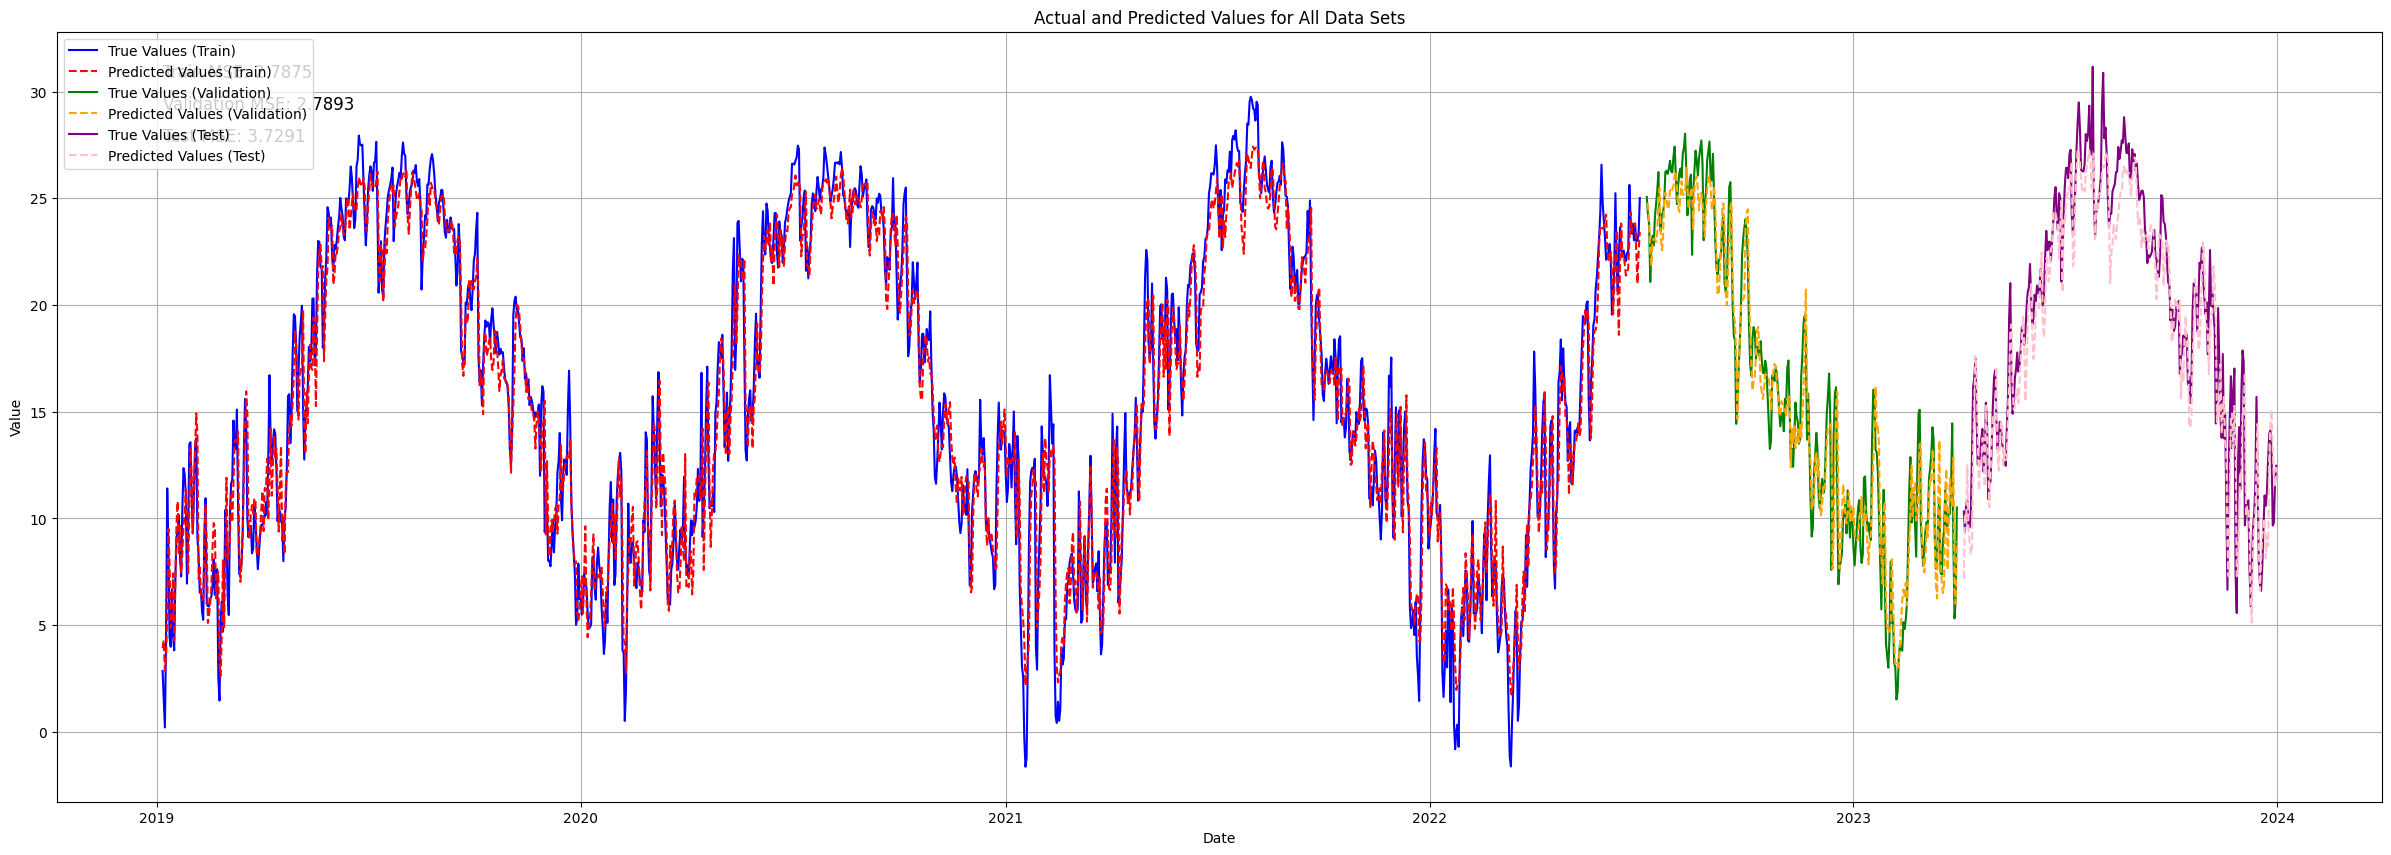

In [ ]:
plot_predictions_with_metrics(train_df, val_df, test_df, true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse, time_steps)